In [96]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# 1. Data:
   Use publicly available stock market data (e.g., Yahoo Finance, Alpha Vantage API, or Kaggle datasets). 
 - Include at least the following features: Open, High, Low, Close, Volume.

In [99]:
# Yahoo Finance Tesla, Inc. (TSLA) Dataset

data = yf.download("TSLA", start="2020-02-03", end="2025-02-03")

print(data.isnull().sum()) # Missing value check

print(data) # Data Preview

[*********************100%***********************]  1 of 1 completed

Price   Ticker
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open    TSLA      0
Volume  TSLA      0
dtype: int64
Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2020-02-03   52.000000   52.409332   44.901333   44.912666  705975000
2020-02-04   59.137333   64.599335   55.591999   58.863998  914082000
2020-02-05   48.980000   56.398666   46.940666   54.883999  726357000
2020-02-06   49.930668   53.055332   45.799999   46.661331  598212000
2020-02-07   49.871334   51.316666   48.666668   48.703335  255952500
...                ...         ...         ...         ...        ...
2025-01-27  397.149994  406.690002  389.000000  394.799988   58125500
2025-01-28  398.089996  400.589996  386.500000  396.910004   48910700
2025-01-29  389.100006  398.589996  384.480011  395.209991   68033600
2025-01-30  400.279999  412.5000

In [101]:
data.describe().T

,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
Close,TSLA,1257.0,2.194561e+02,8.361152e+01,2.408133e+01,1.772900e+02,2.224200e+02,2.625100e+02,4.798600e+02
High,TSLA,1257.0,2.244681e+02,8.557798e+01,2.699067e+01,1.800400e+02,2.278700e+02,2.680000e+02,4.885400e+02
Low,TSLA,1257.0,2.142360e+02,8.166535e+01,2.336733e+01,1.733600e+02,2.176133e+02,2.578600e+02,4.575100e+02
Open,TSLA,1257.0,2.195269e+02,8.379233e+01,2.498000e+01,1.761300e+02,2.232500e+02,2.629200e+02,4.759000e+02
Volume,TSLA,1257.0,1.219721e+08,7.834406e+07,2.940180e+07,7.464330e+07,1.004468e+08,1.400066e+08,9.140820e+08


# 2. Feature Engineering:
   Incorporate technical indicators such as RSI, MACD, and Bollinger Bands into your feature set.
   Add additional features that you believe could improve model performance.

### RSI

Date
2020-02-03           NaN
2020-02-04    100.000000
2020-02-05     41.268983
2020-02-06     44.329147
2020-02-07     44.185456
                 ...    
2025-01-27     44.548362
2025-01-28     44.698092
2025-01-29     47.703468
2025-01-30     52.133950
2025-01-31     53.814614
Name: RSI, Length: 1257, dtype: float64


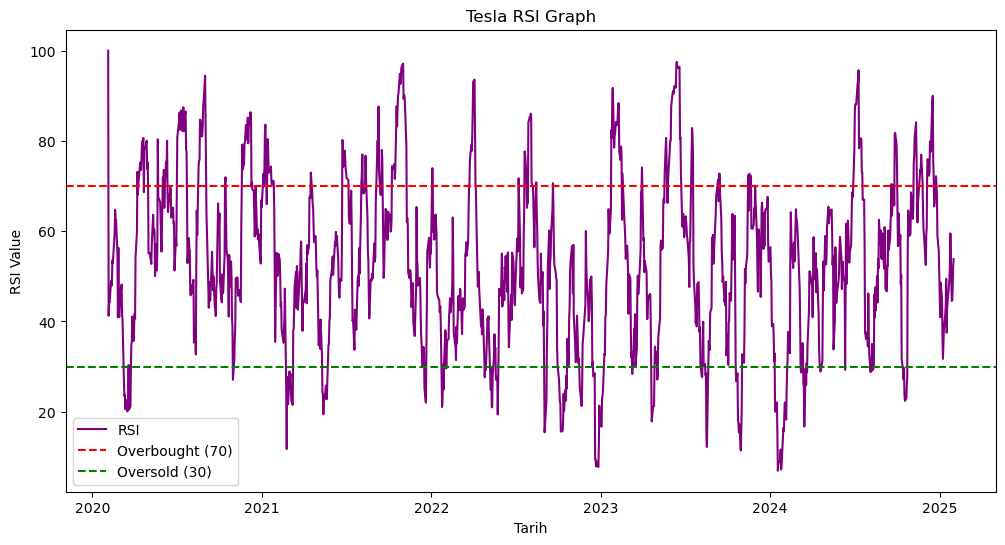

In [105]:
window_length = 14  # A 14-day window is usually used for RSI

# Daily change of closing price
delta = data['Close'].diff()

# Positive and Negative changes
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Average Gain and Loss
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# RSI Calculation
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

print(data['RSI'])

# RSI Graph
plt.figure(figsize=(12,6))
plt.plot(data.index, data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.xlabel("Tarih")
plt.ylabel("RSI Value")
plt.title("Tesla RSI Graph")
plt.legend()
plt.show()

RSI is an indicator that shows the overbought or oversold levels of a stock. Generally, above 70 is considered overbought (sell signal), and below 30 is considered oversold (buy signal).

RSI (Relative Strength Index) helps us understand whether a stock has reached overbought or oversold levels.

RSI > 70 → Overbought zone (Price may fall, sell signal)
RSI < 30 → Oversold zone (Price may rise, buy signal)
If RSI is between 30-70, the price is in balance.

Since RSI is usually calculated based on 14-day averages, the first 14 lines may be NaN.

### MCAD

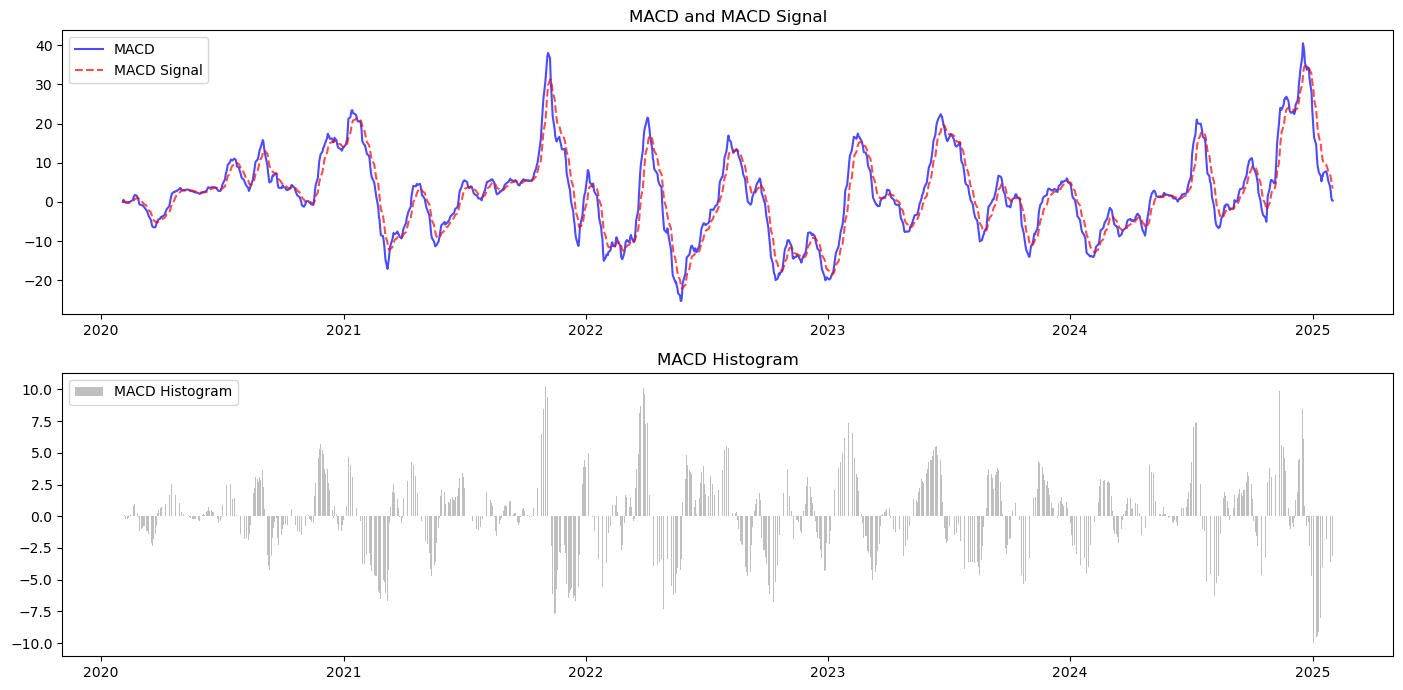

In [109]:
short_window = 12
long_window = 26
signal_window = 9

data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()

data['MACD'] = data['EMA12'] - data['EMA26']
data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

plt.figure(figsize=(14, 7))

# Subplot for MACD and Signal line
plt.subplot(2, 1, 1)
plt.plot(data.index, data['MACD'], label='MACD', color='blue', alpha=0.7)
plt.plot(data.index, data['MACD_Signal'], label='MACD Signal', color='red', linestyle='--', alpha=0.7)
plt.title('MACD and MACD Signal')
plt.legend()

# Subplot for MACD Histogram
plt.subplot(2, 1, 2)
plt.bar(data.index, data['MACD'] - data['MACD_Signal'],
        label='MACD Histogram', color='gray', alpha=0.5)
plt.title('MACD Histogram')
plt.legend()

# Layout adjustment and show plot
plt.tight_layout()
plt.show()

MACD (Moving Average Convergence Divergence)
MACD is an indicator based on the difference between short-term and long-term moving averages. It helps to understand whether the market is in an uptrend or downtrend.

MACD line = 12-day EMA - 26-day EMA
Signal line = 9-day EMA (average of MACD)

### Bollinger Bands

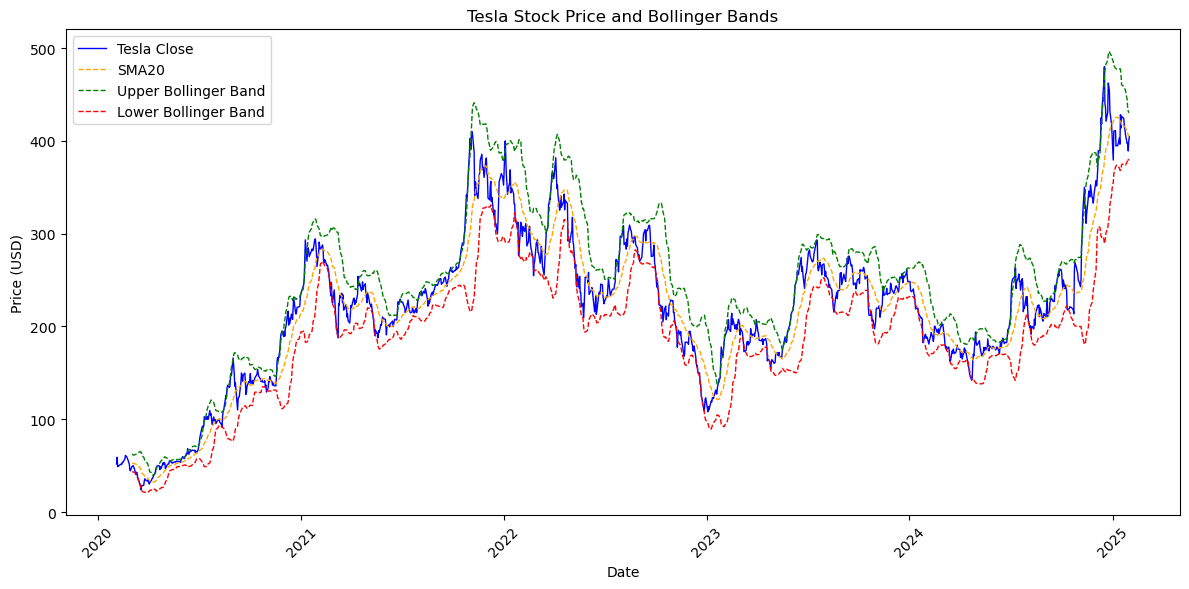

In [112]:
window = 20
data['SMA20'] = data['Close'].rolling(window=window).mean()
data['STD20'] = data['Close'].rolling(window=window).std()

data['BB_High'] = data['SMA20'] + (data['STD20'] * 2)
data['BB_Low'] = data['SMA20'] - (data['STD20'] * 2)


#Visualize Tesla closing prices, SMA20, upper and lower Bollinger Bands
plt.figure(figsize=(12,6))

# Plot the closing price
plt.plot(data['Close'], label='Tesla Close', color='blue', linewidth=1)

# Drawing SMA20
plt.plot(data['SMA20'], label='SMA20', color='orange', linestyle='--', linewidth=1)

# Drawing the upper Bollinger Band
plt.plot(data['BB_High'], label='Upper Bollinger Band', color='green', linestyle='--', linewidth=1)

# Drawing lower Bollinger Band
plt.plot(data['BB_Low'], label='Lower Bollinger Band', color='red', linestyle='--', linewidth=1)

# Title of graph chart
plt.title('Tesla Stock Price and Bollinger Bands')

#X and Y axes
plt.xlabel('Date')
plt.ylabel('Price (USD)')

plt.legend()

# Rotate date labels and make them visible
plt.xticks(rotation=45)

# Graph show
plt.tight_layout()
plt.show()

Bollinger Bands

Bollinger Bands show the volatility of a stock and are used to determine whether the price is overbought or oversold.

Middle Band: 20-day simple moving average (SMA)
Upper Band: Middle Band + (2 * Standard Deviation)
Lower Band: Middle Band - (2 * Standard Deviation)

# 3. Model Development:
     Choose an appropriate predictive modeling approach (e.g., regression, LSTM, or another deep learning model).
     Train the model to predict the next day's closing price of a stock.

### Why We Chose XGBoost?

XGBoost is one of the most powerful regression and classification algorithms in machine learning.

We are making time series prediction (Stock closing price).
Our data is complex and contains financial technical indicators (RSI, MACD, Bollinger Bands etc.). Accuracy is important, but there is also the risk of overfitting. We want a fast model and we should be able to optimize.

XGBoost was chosen because it suits all these needs!

Advantages of XGBoost

Fast and Efficient

It performs parallel calculations, works very fast even on big data.

Better Accuracy It makes powerful predictions because it is based on Decision Trees.

Preventing Overfitting We can prevent overlearning with settings such as max_depth, learning_rate.

Works with Incomplete Data

It can automatically handle missing values.

It can be used for both regression (price prediction) and classification (will it rise or fall?).

In [115]:
# Determine Properties and Target Variable
X = data[['Open', 'High', 'Low', 'Volume', 'RSI', 'MACD', 'BB_High', 'BB_Low']]
y = data['Close'].shift(-1)  # To predict the next day's closing price

# Clean NaN values from last line
X = X[:-1]
y = y[:-1]

# Training and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# 4. Evaluation:    Use appropriate evaluation metrics (e.g., RMSE, MAPE, or R-squared) to assess your model's performance.   - Provide a detailed explanation of why you selected the chosen metric(s).

RMSE (Root Mean Squared Error) Measures the average prediction error of the model. Lower RMSE is better.

MAPE (Mean Absolute Percentage Error) Shows the prediction error of the model as a percentage. Lower MAPE is better.

R² (R-Square Score) Measures the explanatory power of the model. Close to 1 is good.

XGBoost Model RMSE: 9.29
XGBoost Model MAPE: 3.37%
XGBoost Model R² Skoru: 0.9876


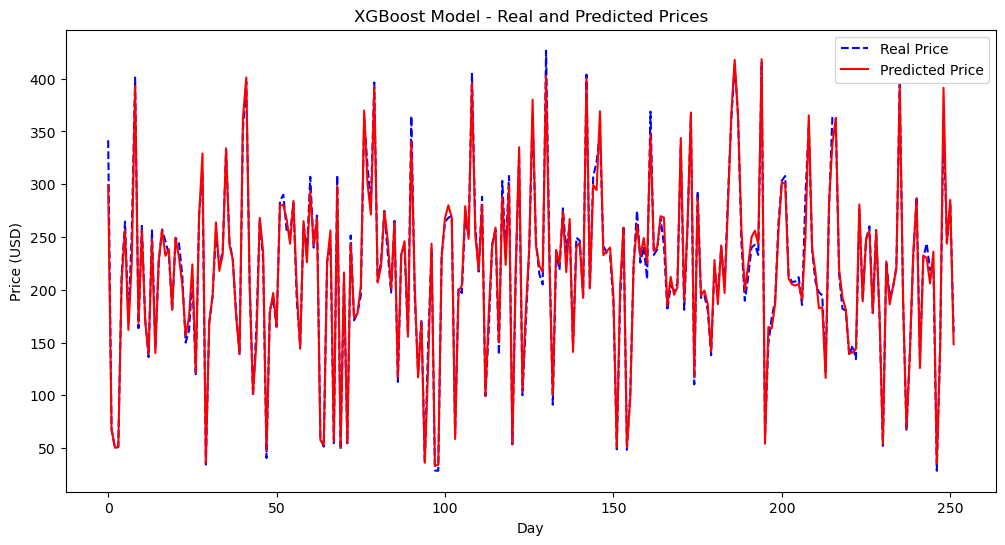

In [118]:
# RMSE Error (Root Mean Square Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"XGBoost Model RMSE: {rmse:.2f}")

# MAPE Error (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"XGBoost Model MAPE: {mape:.2%}")

# R-Square Score (Explanatory Score)
r2 = r2_score(y_test, y_pred)
print(f"XGBoost Model R² Skoru: {r2:.4f}")


plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Real Price", color="blue", linestyle="dashed")
plt.plot(y_pred, label="Predicted Price", color="red")
plt.xlabel("Day")
plt.ylabel("Price (USD)")
plt.title("XGBoost Model - Real and Predicted Prices")
plt.legend()
plt.show()

# 5 Results

✅ RMSE: 9.29 
✅ MAPE: %3.37 
✅ R²: 0.9876 

### RMSE (Root Mean Squared Error)"The model's predictions deviate from actual prices by an average of $9.29"

### MAPE (Mean Absolute Percentage Error)

The model's predictions deviate from actual prices by an average of 3.37%.

This metric measures the model's error rate as a percentage. A MAPE below 5% indicates that the model is performing well.

### R² (Determination Coefficient)
The model explains 98.76% of the data.

The higher the R² value, the stronger the relationship between the model's predicted prices and the actual prices.

0.9876 is a very high value, the model explains the data very well.

However, an R² of 0.98+ may be a sign of overfitting.

The model may have learned past data very well, but may have difficulty adapting to new data in the future.

# 6 References

-  https://gedik.com/yazilar/yatirim/macd-nedir-nasil-kullanilir

-  https://www.alnusyatirim.com/rsi-nedir

-  https://www.qnbinvest.com.tr/forex/forex-terimler-sozlugu/bollinger-bantlari-nedir

-  https://efecanxrd.medium.com/xgboost-algoritmas%C4%B1-6703b14efd5